# DTSA 5511 Deep Learning Final Project

## Imports and configs

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, ReLU
from keras import Input
from keras.optimizers.legacy import Adam
from keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.image as mpimg
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D

py.init_notebook_mode(connected=True)

## Description of the problem and data source

I chose to use a dataset from the Kaggle competition [Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/competitions/statoil-iceberg-classifier-challenge/overview).

The challenge is about drifting icebergs that present threats to navigation and activities in areas such as offshore of the East Coast of Canada. 

The goal of this project is to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg based on satellite images and labels provided by human experts and geographic knowledge on the target.

## Data

**1604** images (flattened image data) with dimensions **75 x 75** pixels - identified by an **id** and labeled with **0 (not-iceberg)** or **1 (iceberg)**

**band_1, band_2**

The flattened image data. These are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically).

**inc_angle**

The incidence angle of which the image was taken. Note that this field has missing data marked as "na".

In [2]:
df = pd.read_json("train.json")
df.inc_angle = pd.to_numeric(df.inc_angle, errors='coerce')
print("Images: ", df.shape[0])
df.head()

Images:  1604


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


## Exploratory Data Analysis (EDA)

### Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1604 non-null   object 
 1   band_1      1604 non-null   object 
 2   band_2      1604 non-null   object 
 3   inc_angle   1471 non-null   float64
 4   is_iceberg  1604 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 62.8+ KB


In [4]:
df.describe(include='all')

,id,band_1,band_2,inc_angle,is_iceberg
count,1604,1604,1604,1471.000000,1604.000000
unique,1604,1604,1604,NaN,NaN
top,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,39.268707,0.469451
std,NaN,NaN,NaN,3.839744,0.499222
min,NaN,NaN,NaN,24.754600,0.000000
25%,NaN,NaN,NaN,36.106100,0.000000
50%,NaN,NaN,NaN,39.501500,0.000000
75%,NaN,NaN,NaN,42.559100,1.000000


There are **133 images** with missing data for the feature **inc_angle**.

So the idea is to take a look at the distribution of this feature and imputate these missing values.

Text(0.5, 1.0, 'Histogram: inc_angle')

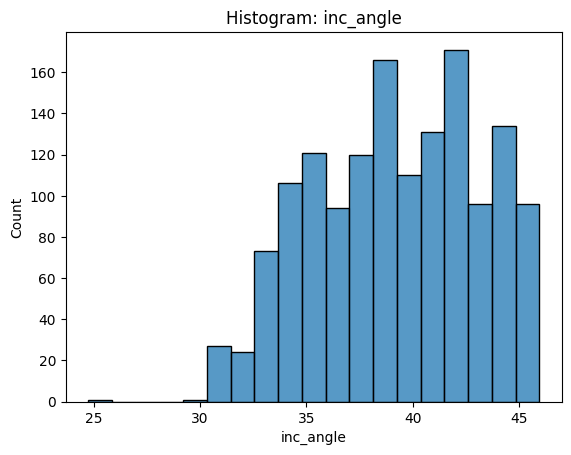

In [5]:
sns.histplot(df, x="inc_angle").set_title('Histogram: inc_angle')

#### Data imputation

As the distribution is well behaved, I decide to imputate with the average of the feature.

In [6]:
imputer = SimpleImputer(strategy='mean')
df[["inc_angle"]] = imputer.fit_transform(df[["inc_angle"]])

df.describe(include = "all")

,id,band_1,band_2,inc_angle,is_iceberg
count,1604,1604,1604,1604.000000,1604.000000
unique,1604,1604,1604,NaN,NaN
top,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,39.268707,0.469451
std,NaN,NaN,NaN,3.677005,0.499222
min,NaN,NaN,NaN,24.754600,0.000000
25%,NaN,NaN,NaN,36.483175,0.000000
50%,NaN,NaN,NaN,39.268707,0.000000
75%,NaN,NaN,NaN,42.512800,1.000000


### Data visualization

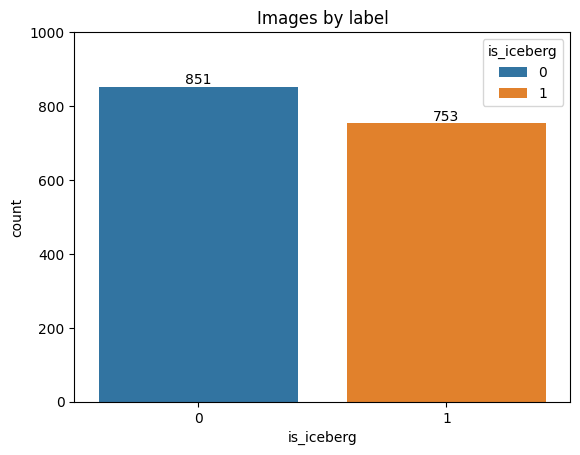

In [7]:
ax = sns.countplot(df, x="is_iceberg", hue="is_iceberg")
ax.set_title("Images by label")
plt.ylim(0, 1000)
for i in ax.containers:
    ax.bar_label(i)

#### Sample of images

I did some adjustments in the function below (plotmy3d) that was created by https://www.kaggle.com/devm2024 to show a 3D representation of the image flattened data.

In [8]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])

def plotmy3d(c, name, color="Blues"):
    data = [go.Surface(z=c, colorscale=color, cmin=-25,cmax=0, reversescale=True)]
    layout = go.Layout(title=name, autosize=False, width=700, height=700, margin=dict(l=65, r=50, b=65, t=90))
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [9]:
plotmy3d(X_band_1[5,:,:], 'Iceberg')

In [10]:
plotmy3d(X_band_1[12,:,:], 'Iceberg')

In [11]:
plotmy3d(X_band_1[14,:,:], 'Ship', 'RdBu')

In [12]:
plotmy3d(X_band_1[3,:,:], 'Ship', 'RdBu')

#### Histograms of some features

Text(0.5, 1.0, 'Histogram: min_band_1')

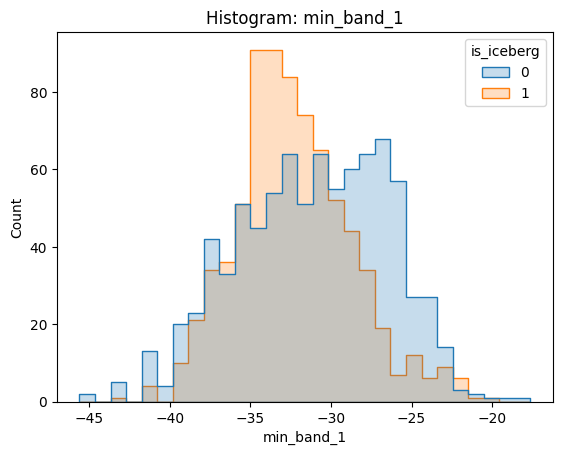

In [13]:
df['min_band_1'] = [np.min(np.array(x)) for x in df['band_1']]
sns.histplot(df, x="min_band_1", hue="is_iceberg", element="step").set_title('Histogram: min_band_1')

Text(0.5, 1.0, 'Histogram: max_band_1')

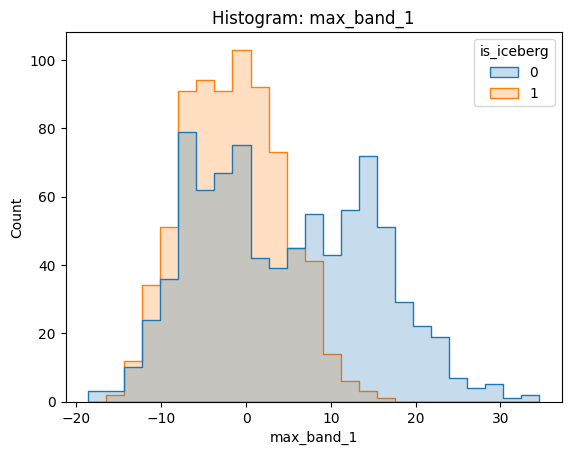

In [14]:
df['max_band_1'] = [np.max(np.array(x)) for x in df['band_1']]
sns.histplot(df, x="max_band_1", hue="is_iceberg", element="step").set_title('Histogram: max_band_1')

Text(0.5, 1.0, 'Histogram: min_band_2')

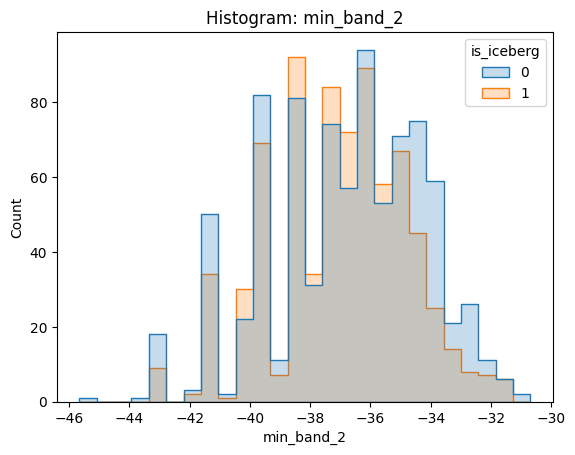

In [15]:
df['min_band_2'] = [np.min(np.array(x)) for x in df['band_2']]
sns.histplot(df, x="min_band_2", hue="is_iceberg", element="step").set_title('Histogram: min_band_2')

Text(0.5, 1.0, 'Histogram: max_band_2')

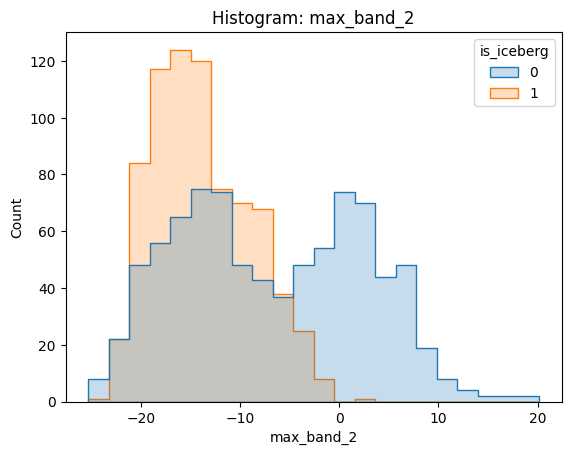

In [16]:
df['max_band_2'] = [np.max(np.array(x)) for x in df['band_2']]
sns.histplot(df, x="max_band_2", hue="is_iceberg", element="step").set_title('Histogram: max_band_2')

Text(0.5, 1.0, 'Correlation matrix')

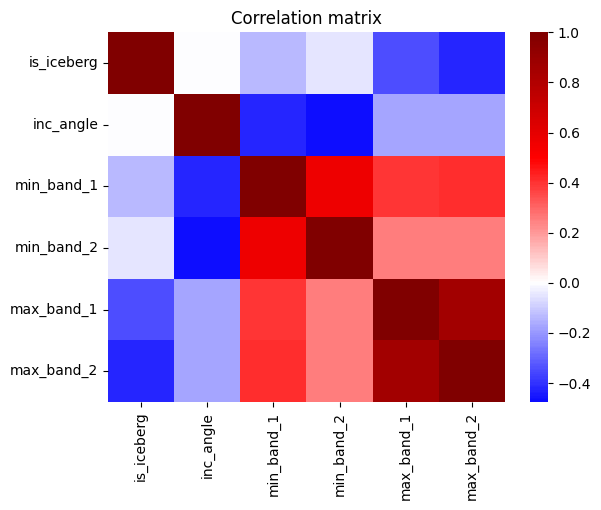

In [17]:
sns.heatmap(df[["is_iceberg","inc_angle","min_band_1","min_band_2","max_band_1","max_band_2"]].corr(), annot=False, cmap = 'seismic', center=0).set_title('Correlation matrix')

## Model Architecture
The plan is to train a Convolutional Neural Network (CNN) with Keras to predict if it's an iceberg or a ship based on the input images. 

I will split the data in train and validation sets to use at training the model and evaluating the results.

I also rescale the values on the images to normalize them in order to improve the training process.

### Preparing data for training and validation

In [18]:
def rescale_bands(row):
    band_1 = np.array(row.band_1).reshape(75, 75)
    band_1_scaled = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
    band_2 = np.array(row.band_2).reshape(75, 75)
    band_2_scaled = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
    return np.dstack((band_1_scaled, band_2_scaled))

X = np.array(df.apply(rescale_bands, axis=1).tolist())
y = np.array(df.is_iceberg)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=df.is_iceberg, random_state=0)

IMAGE_SHAPE = (75, 75, 2)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (1604, 75, 75, 2)
y shape:  (1604,)


### Model 1

A very simple Neural Network architecture for a binary classification problem to have a baseline for further improvements.

- Model Type: Sequential, with a simple linear stack of layers.
- Input Handling: The input is flattened, making it suitable for dense layers.
- Layer Composition: Consists of a flattening layer, a dense layer with 8 neurons, and an output layer with a single neuron and sigmoid activation.
- Task: Designed for a binary classification task.
- Optimization: Uses the Adam optimizer with a low learning rate for fine-tuned adjustments during training.
- Loss and Metrics: Employs binary crossentropy as the loss function and accuracy as the performance metric.
- Training: Configured to train over 30 epochs, with real-time feedback on performance via validation data.

In [19]:
model1 = Sequential()
model1.add(Input(shape=IMAGE_SHAPE))
model1.add(Flatten())

model1.add(Dense(8))

model1.add(Dense(1, activation="sigmoid"))
model1.compile(Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])

h1 = model1.fit(X_train, y_train, epochs = 30, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/30


2024-06-25 00:05:18.256376: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-25 00:05:18.256393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-25 00:05:18.256397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-25 00:05:18.256589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-25 00:05:18.256608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 1/41 [..............................] - ETA: 12s - loss: 0.6999 - accuracy: 0.4375

2024-06-25 00:05:18.545126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 11ms/step - loss: 0.6745 - accuracy: 0.5690 - val_loss: 0.6475 - val_accuracy: 0.6636
Epoch 2/30
41/41 [==============================] - 0s 5ms/step - loss: 0.6065 - accuracy: 0.7366 - val_loss: 0.6135 - val_accuracy: 0.6760
Epoch 3/30
41/41 [==============================] - 0s 5ms/step - loss: 0.5592 - accuracy: 0.8020 - val_loss: 0.5897 - val_accuracy: 0.7009
Epoch 4/30
41/41 [==============================] - 0s 5ms/step - loss: 0.5210 - accuracy: 0.8457 - val_loss: 0.5741 - val_accuracy: 0.7134
Epoch 5/30
41/41 [==============================] - 0s 5ms/step - loss: 0.4881 - accuracy: 0.8683 - val_loss: 0.5613 - val_accuracy: 0.7321
Epoch 6/30
41/41 [==============================] - 0s 5ms/step - loss: 0.4603 - accuracy: 0.8823 - val_loss: 0.5521 - val_accuracy: 0.7196
Epoch 7/30
41/41 [==============================] - 0s 5ms/step - loss: 0.4356 - accuracy: 0.8940 - val_loss: 0.5450 - val_accuracy: 0.7321
Epoch 8/30
41/41 [============

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 11250)             0         
                                                                 
 dense (Dense)               (None, 8)                 90008     
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 90017 (351.63 KB)
Trainable params: 90017 (351.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model 2

Model 1 added with a Convolutional Neural Network (CNN) architecture. The idea is to apply what is well known for problems image based.

- Convolutional Layers: The model starts with three convolutional layers, each increasing in complexity (64, 128, 256 filters). The kernel sizes also progressively increase from 3x3 to 5x5, which might help in capturing more detailed features at each stage.

- Pooling and Dropout: Each convolutional layer is followed by a max-pooling layer to down-sample the input and a dropout layer to prevent overfitting. The dropout rates gradually increase, reflecting the deeper the network, the more regularization might be necessary.

- Fully Connected Layers: After flattening the output from the convolutional layers, the model has a dense layer with 256 units for further learning from the extracted features, followed by a dropout layer with a higher rate to reduce overfitting further.

- Output Layer: The final dense layer with a single neuron and sigmoid activation function is suited for binary classification tasks, outputting a probability between 0 and 1.

- Optimization and Learning: The model is compiled with the Adam optimizer, suitable for its adaptive learning rate capabilities, and a binary crossentropy loss function, common for binary classification.

- Learning Rate Adjustment: The ReduceLROnPlateau callback ensures that the learning rate is adjusted dynamically based on the validation accuracy, potentially improving training stability and convergence.

In [21]:
model2 = Sequential()
model2.add(Input(shape=IMAGE_SHAPE))

model2.add(Conv2D(filters=64, kernel_size=3))
model2.add(ReLU())
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(Dropout(0.3))

model2.add(Conv2D(filters=128, kernel_size=4))
model2.add(ReLU())
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(Dropout(0.3))

model2.add(Conv2D(filters=256, kernel_size=5))
model2.add(ReLU())
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(Dropout(0.4))

model2.add(Flatten())

model2.add(Dense(256))
model2.add(ReLU())
model2.add(Dropout(0.5))

model2.add(Dense(1, activation="sigmoid"))
model2.compile(Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])

lr_decay = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.5, patience = 3, min_lr = 0.00001)

h2 = model2.fit(X_train, y_train, batch_size=24, epochs = 30, verbose = 1, validation_data = (X_val, y_val), callbacks = [lr_decay])

Epoch 1/30
54/54 [==============================] - 3s 56ms/step - loss: 0.6819 - accuracy: 0.5659 - val_loss: 0.6656 - val_accuracy: 0.6978 - lr: 1.0000e-04
Epoch 2/30
54/54 [==============================] - 3s 49ms/step - loss: 0.6449 - accuracy: 0.5994 - val_loss: 0.6316 - val_accuracy: 0.7165 - lr: 1.0000e-04
Epoch 3/30
54/54 [==============================] - 3s 51ms/step - loss: 0.5858 - accuracy: 0.6843 - val_loss: 0.5430 - val_accuracy: 0.7913 - lr: 1.0000e-04
Epoch 4/30
54/54 [==============================] - 3s 49ms/step - loss: 0.4842 - accuracy: 0.7607 - val_loss: 0.4483 - val_accuracy: 0.8193 - lr: 1.0000e-04
Epoch 5/30
54/54 [==============================] - 3s 49ms/step - loss: 0.4171 - accuracy: 0.8020 - val_loss: 0.4239 - val_accuracy: 0.8100 - lr: 1.0000e-04
Epoch 6/30
54/54 [==============================] - 3s 49ms/step - loss: 0.3738 - accuracy: 0.8332 - val_loss: 0.3934 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 7/30
54/54 [==============================] - 

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1216      
                                                                 
 re_lu (ReLU)                (None, 73, 73, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 128)       131200    
                                                                 
 re_lu_1 (ReLU)              (None, 33, 33, 128)       0         
                                                      

### Model 3

Model 2 plus data augmentation techniques and some minor adjustments

In [23]:
model3 = Sequential()
model3.add(Input(shape=IMAGE_SHAPE))

model3.add(Conv2D(filters=64, kernel_size=3))
model3.add(ReLU())
model3.add(MaxPooling2D(pool_size=2, strides=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=128, kernel_size=4))
model3.add(ReLU())
model3.add(MaxPooling2D(pool_size=2, strides=2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=256, kernel_size=5))
model3.add(ReLU())
model3.add(MaxPooling2D(pool_size=2, strides=2))
model3.add(Dropout(0.3))

model3.add(Flatten())

model3.add(Dense(256))
model3.add(ReLU())
model3.add(Dropout(0.4))

model3.add(Dense(1, activation="sigmoid"))
model3.compile(Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])

lr_decay = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.5, patience = 3, min_lr = 0.00001)

gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
gen.fit(X_train)

h3 = model3.fit(gen.flow(X_train, y_train, batch_size=24), epochs=30, verbose=1, validation_data=(X_val, y_val), callbacks=[lr_decay])

Epoch 1/30


/opt/miniconda3/lib/python3.10/site-packages/keras/src/preprocessing/image.py:2093: UserWarning:

Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1283, 75, 75, 2) (2 channels).

/opt/miniconda3/lib/python3.10/site-packages/keras/src/preprocessing/image.py:766: UserWarning:

NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1283, 75, 75, 2) (2 channels).



54/54 [==============================] - 3s 57ms/step - loss: 0.6862 - accuracy: 0.5323 - val_loss: 0.6677 - val_accuracy: 0.5109 - lr: 1.0000e-04
Epoch 2/30
54/54 [==============================] - 3s 52ms/step - loss: 0.6510 - accuracy: 0.5744 - val_loss: 0.6325 - val_accuracy: 0.6916 - lr: 1.0000e-04
Epoch 3/30
54/54 [==============================] - 3s 52ms/step - loss: 0.5935 - accuracy: 0.6672 - val_loss: 0.5322 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 4/30
54/54 [==============================] - 3s 50ms/step - loss: 0.4880 - accuracy: 0.7576 - val_loss: 0.4534 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 5/30
54/54 [==============================] - 3s 50ms/step - loss: 0.4345 - accuracy: 0.8012 - val_loss: 0.4690 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 6/30
54/54 [==============================] - 3s 50ms/step - loss: 0.3989 - accuracy: 0.8161 - val_loss: 0.3807 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 7/30
54/54 [==============================] - 3s 49ms/ste

In [24]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 73, 73, 64)        1216      
                                                                 
 re_lu_4 (ReLU)              (None, 73, 73, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 33, 33, 128)       131200    
                                                                 
 re_lu_5 (ReLU)              (None, 33, 33, 128)       0         
                                                      

## Results

Below are results of each model and the plots with the training history of the models.

**Model 2** is the best! (considering f1 score and AUC)

In [25]:
def get_results(model):
    y_pred = model.predict(X_val)>0.5
    y_true = y_val
    print(classification_report(y_true, y_pred, target_names=["Ship", "Iceberg"]))

for i,m in enumerate([model1,model2,model3]):
    print(f"Model {i+1}")
    print(" ")
    get_results(m)
    print(" ")

Model 1
 
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        Ship       0.73      0.68      0.71       170
     Iceberg       0.67      0.72      0.69       151

    accuracy                           0.70       321
   macro avg       0.70      0.70      0.70       321
weighted avg       0.70      0.70      0.70       321

 
Model 2
 
11/11 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

        Ship       0.92      0.82      0.87       170
     Iceberg       0.82      0.92      0.87       151

    accuracy                           0.87       321
   macro avg       0.87      0.87      0.87       321
weighted avg       0.87      0.87      0.87       321

 
Model 3
 
11/11 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

        Ship       0.89      0.85      0.87       170
     Iceberg       0.84      0.88      0.8

In [26]:
def show_model_history(h, model):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"Model {model} training history", fontsize=13, fontweight='bold')
    axs[0].plot(h.history['accuracy'], label='train')
    axs[0].plot(h.history['val_accuracy'], label='validation')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')
    axs[1].plot(h.history['loss'], label='train')
    axs[1].plot(h.history['val_loss'], label='validation')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

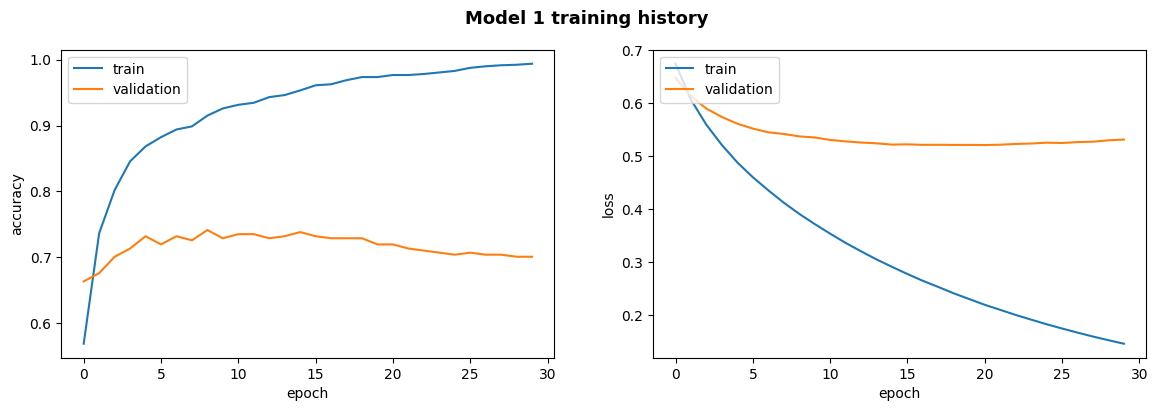

In [27]:
show_model_history(h1, "1")

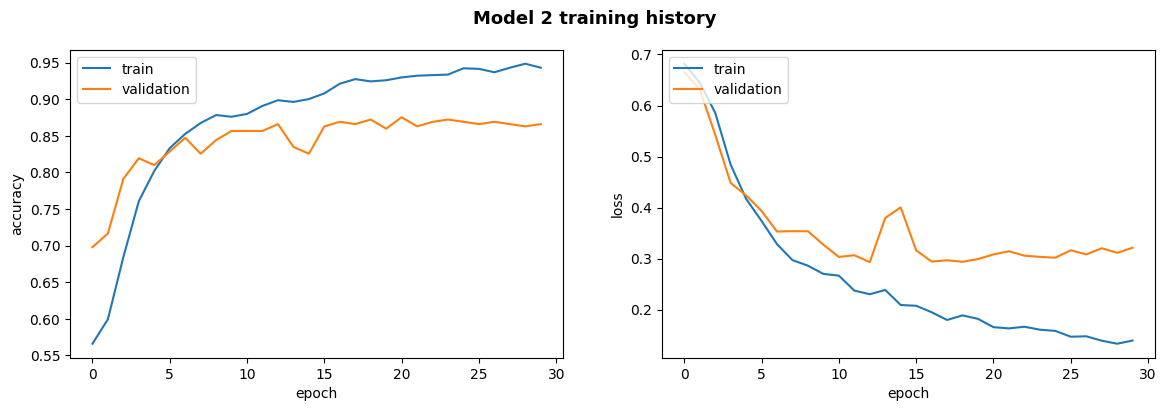

In [28]:
show_model_history(h2, "2")

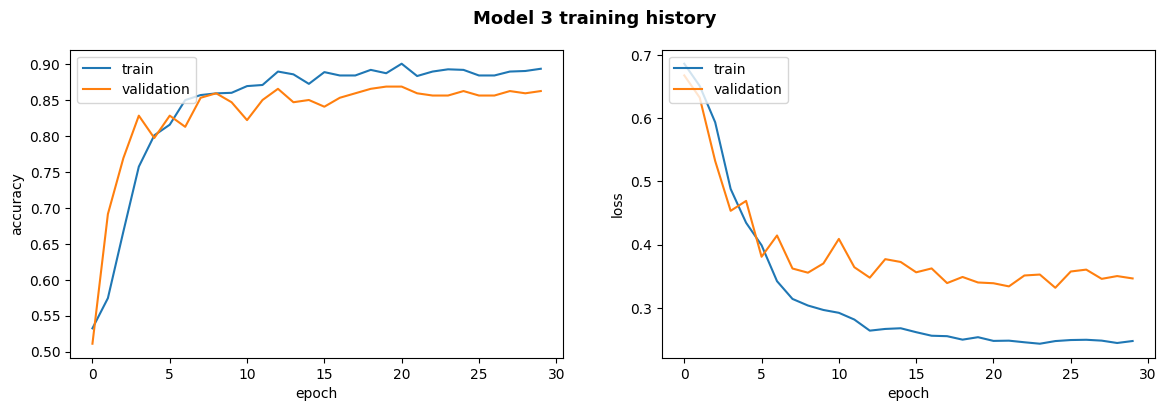

In [29]:
show_model_history(h3, "3")

### Validation data results of the best model

11/11 [==============================] - 0s 16ms/step


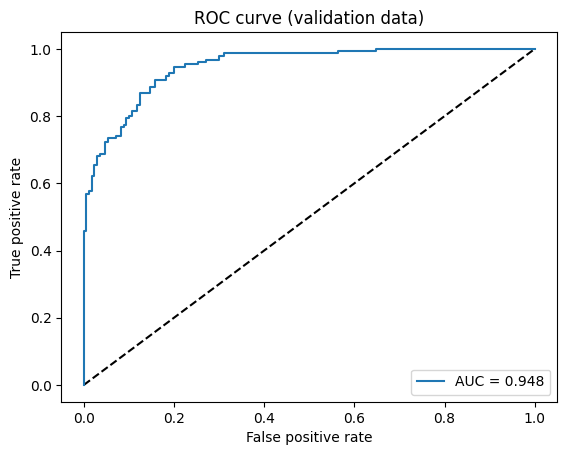

In [35]:
y_pred = model2.predict(X_val)
y_true = y_val

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve (validation data)")
plt.legend(loc="best")
plt.show()

### Submission

In [31]:
df_test = pd.read_json("test.json")
X_test = np.array(df_test.apply(rescale_bands, axis=1).tolist())
df_test["is_iceberg"] = model2.predict(X_test)
submission = df_test[["id", "is_iceberg"]]
print(submission.head(10))
submission.to_csv("submission.csv", index = False)

264/264 [==============================] - 4s 16ms/step
         id  is_iceberg
0  5941774d    0.590953
1  4023181e    0.478243
2  b20200e4    0.262550
3  e7f018bb    0.999690
4  4371c8c3    0.437106
5  a8d9b1fd    0.964016
6  29e7727e    0.038775
7  92a51ffb    0.999934
8  c769ac97    0.001806
9  aee0547d    0.018418


## Conclusion

After exploring different Convolutional Neural Network architectures, it's very clear for me that this approach is very powerful for image problems. Increasing the amount of convolutional and max pooling layers has a considerable effect on the metrics for train and validation data. Also, it was important to change the kernel size and playing around with layers of different sizes.

A lesson learned is that in this case data augmentation didn't improve the metrics of the model. Maybe because I just used a image with 2 channels instead of 3. This is something to improve in next iterations with this challenge.

One possible next step would be to explore more the other features that were not used as for example the incidence angle of which the image was taken. Probably this can improve the predictions. By the way, the Kaggle score for the submission with the Model 2 was 0.20579 (submissions were evaluated on the log loss between the predicted values and the ground truth).